This notebook is used to test the MaxFuse algorithm on a subset of CODEX CD8's, as well as to perform the final integration.

In [4]:
import maxfuse as mf
import anndata
import pandas as pd
import scanpy as scp
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

from utils import CELLTYPE_COLOR_DICT

import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from matplotlib import colors

%load_ext jupyter_black

protein_map = pd.read_csv(
    "2022_11_16_Protein-Gene mapping_markers for data integration_edited.csv"
)

# Remove non-relevant antigens
protein_map = protein_map[protein_map["Comment"].isnull()]
# Remove whitespace from marker names
protein_map["Antigen (CODEX)"] = protein_map["Antigen (CODEX)"].str.strip()
protein_map["Gene"] = protein_map["Gene"].str.strip()

obs_columns = [
    "Unnamed: 0",
    "X",
    "index",
    "Object.Id",
    "XMin",
    "XMax",
    "YMin",
    "YMax",
    "Tissue",
    "Patient",
    "Celltype",
    "Class",
    "Class0",
]

marker_columns = [
    "CD56.Cytoplasm.Intensity",
    "CD161.Cytoplasm.Intensity",
    "TCRValpha.Cytoplasm.Intensity",
    "CD39.Cytoplasm.Intensity",
    "CD25.Cytoplasm.Intensity",
    "CD57.Cytoplasm.Intensity",
    "CD40.Cytoplasm.Intensity",
    "ICOS.Cytoplasm.Intensity",
    "CD3.Cytoplasm.Intensity",
    "CD62L.Cytoplasm.Intensity",
    "LYVE.1.Cytoplasm.Intensity",
    "CD45RO.Cytoplasm.Intensity",
    "IL18Ra.Cytoplasm.Intensity",
    "PD.L1.Cytoplasm.Intensity",
    "CD45.Cytoplasm.Intensity",
    "CD34.Cytoplasm.Intensity",
    "CD163.Cytoplasm.Intensity",
    "Ki67.Nucleus.Intensity",
    "CD19.Cytoplasm.Intensity",
    "CD38.Cytoplasm.Intensity",
    "CD279.Cytoplasm.Intensity",
    "CD11c.Cytoplasm.Intensity",
    "CD8.Cytoplasm.Intensity",
    "CD11b.Cytoplasm.Intensity",
    "CD16.Cytoplasm.Intensity",
    "FoxP3.Nucleus.Intensity",
    "CD69.Cytoplasm.Intensity",
    "CD15.Cytoplasm.Intensity",
    "HNFalpha.Nucleus.Intensity",
    "pancytokeratin.Cytoplasm.Intensity",
    "HLADR.Cytoplasm.Intensity",
    "CD45RA.Cytoplasm.Intensity",
    "aSMA.Cytoplasm.Intensity",
    "CD4.Cytoplasm.Intensity",
    "CD66b.Cytoplasm.Intensity",
    "CD68.Cytoplasm.Intensity",
    "EPCAM.Cytoplasm.Intensity",
]

In [ ]:
# Load datasets
adata = anndata.read("CODEX_cd8.h5ad")
sc_adata = anndata.read("adata_CD8_velocity_all.h5ad")

# Extract marker names
markers = []
for column in marker_columns:
    if "Intensity" in column:
        markers.append("-".join(column.split(".")[:-2]))

# Process the protein-gene mapping
protein_map_dict = {}
for marker in markers:
    gene_aliases = protein_map[protein_map["Antigen (CODEX)"] == marker][
        "Gene"
    ].values.reshape(-1)
    # print(marker, gene_aliases)
    protein_map_dict[marker] = []
    for gene_name in gene_aliases:
        split = gene_name.split(",")
        for name in split:
            protein_map_dict[marker].append(name.strip())


# Filter to shared and higly variable markers
markers_to_keep = []
genes_to_keep = []
for key, values in protein_map_dict.items():
    for gene in values:  # in case protein matches to more than one gene
        if (
            gene in sc_adata.var[sc_adata.var["highly_variable"]].index.values
        ):  # keep only higly variable genes
            genes_to_keep.append(gene)
            markers_to_keep.append(key)  
        else:
            print(gene)

adata.var_names = markers
adata = adata[adata.obs["Class0"] != "T cells CD8 PD-L1+"]
adata_compare = adata[:, markers_to_keep].copy()

In [ ]:
# Preprocess data matrices 
sc_adata.X = sc_adata.raw.X.copy()
sc_adata_compare = sc_adata[:, genes_to_keep].copy()

sc_adata.X = sc_adata.raw.X.copy()
sc_adata_compare = sc_adata[:, genes_to_keep].copy()

scp.pp.normalize_total(sc_adata)
scp.pp.log1p(sc_adata)
scp.pp.scale(sc_adata)

scp.pp.normalize_total(sc_adata_compare)
scp.pp.log1p(sc_adata_compare)
scp.pp.scale(sc_adata_compare)

rna_shared = sc_adata_compare.X.copy()
protein_shared = adata_compare.X.copy()
rna_active = sc_adata[:, sc_adata.var["highly_variable"]].X
protein_active = adata.X

rna_active = rna_active.toarray()

In [54]:
# Create MaxFuse object
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=sc_adata.obs["Cluster label"],
    labels2=None,
)

In [55]:
# Split data into batches for more efficient computations
fusor.split_into_batches(
    max_outward_size=8000, matching_ratio=4, metacell_size=2, verbose=True
)

The first data is split into 1 batches, average batch size is 11766, and max batch size is 11766.
The second data is split into 6 batches, average batch size is 34742, and max batch size is 34744.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5'].


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

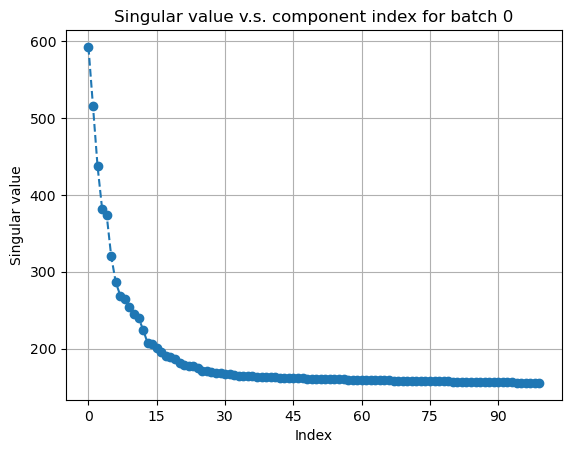

In [56]:
fusor.plot_singular_values(
    target="active_arr1",
    n_components=None,  
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 4'}, xlabel='Index', ylabel='Singular value'>)

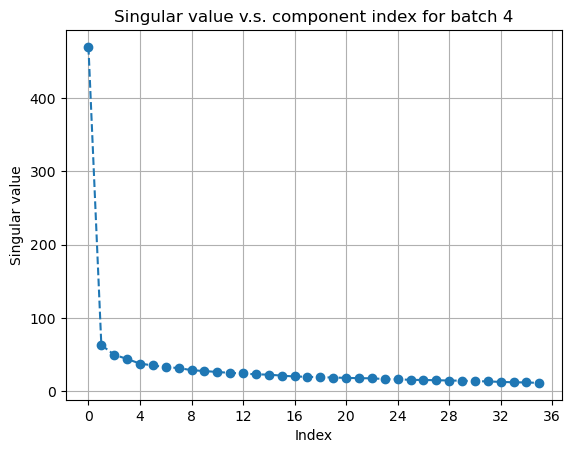

In [57]:
fusor.plot_singular_values(target="active_arr2", n_components=None)

In [58]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=10,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True,
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Graph clustering finished!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

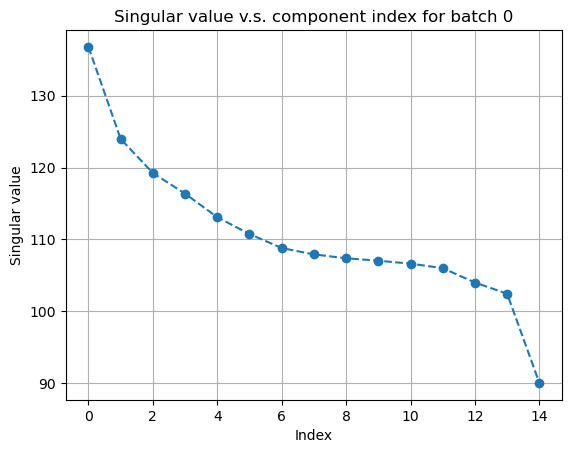

In [59]:
fusor.plot_singular_values(
    target="shared_arr1",
    n_components=None,
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 4'}, xlabel='Index', ylabel='Singular value'>)

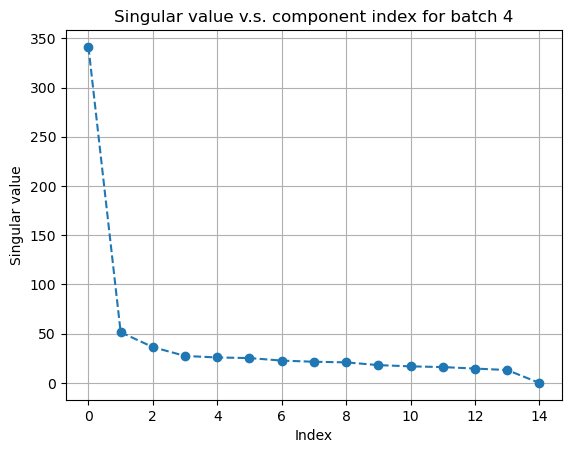

In [60]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(target="shared_arr2", n_components=None)

In [61]:
fusor.find_initial_pivots(wt1=0.3, wt2=0.3, svd_components1=14, svd_components2=10)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Done!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->5'}, xlabel='Index', ylabel='Canonical correlation'>)

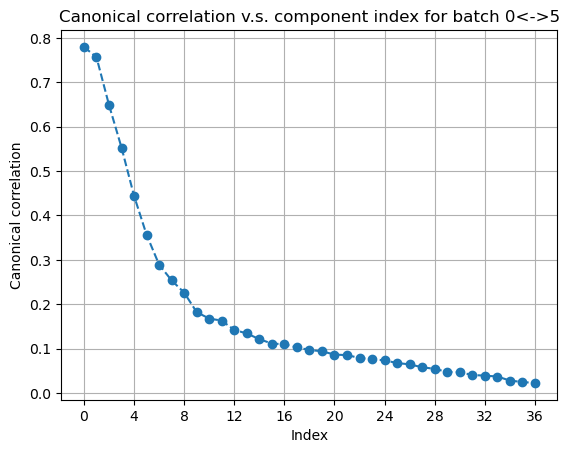

In [62]:
# Plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50, svd_components2=None, cca_components=37
)

In [63]:
fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=50,
    svd_components2=None,
    cca_components=30,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Done!


In [64]:
fusor.filter_bad_matches(target="pivot", filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
17652/35298 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
9239/11766 cells in arr1 are selected as pivots.
17652/208454 cells in arr2 are selected as pivots.
Done!


In [65]:
# Evaluate pivot matching
pivot_matching = fusor.get_matching(order=(2, 1), target="pivot")

rna_pd1_levels = ["PD1hi" in x for x in sc_adata.obs["Cluster label"]]
rna_pd1_levels = np.array(["PD1-high" if x else "PD1-low" for x in rna_pd1_levels])

protein_pd1_levels = (adata.obs["Class0"] == "T cells CD8 PD-1high").values
protein_pd1_levels = np.array(
    ["PD1-high" if x else "PD1-low" for x in protein_pd1_levels]
)


lv1_acc = mf.metrics.get_matching_acc(
    matching=pivot_matching,
    labels1=rna_pd1_levels,
    labels2=protein_pd1_levels,
    order=(2, 1),
)
lv1_acc

0.7822909585316111

Accuracy: 0.7822909585316111
F1-high: 0.5737104825291182
F1-low: 0.8538171858952414
F1-avg: 0.7137638342121797
              precision    recall  f1-score   support

    PD1-high       0.55      0.60      0.57      4286
     PD1-low       0.87      0.84      0.85     13366

    accuracy                           0.78     17652
   macro avg       0.71      0.72      0.71     17652
weighted avg       0.79      0.78      0.79     17652



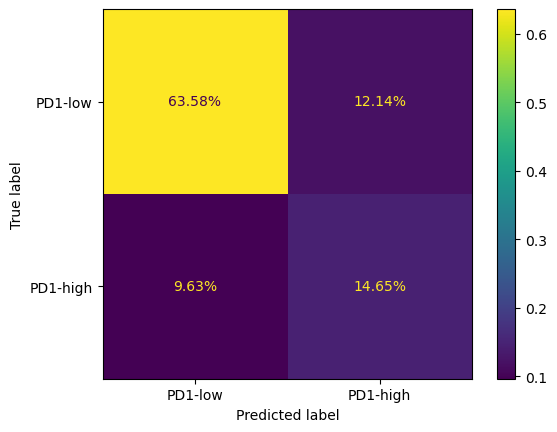

In [96]:
# Filter matches such that each pivot in the CODEX data only retains one scRNA-seq match
pivot_matching_filtered = mf.match_utils.address_matching_redundancy(
    pivot_matching, order=(2, 1)
)

predicted_pd1_levels = rna_pd1_levels[pivot_matching_filtered[0]]
true_pd1_levels = protein_pd1_levels[pivot_matching_filtered[1]]

accuracy = accuracy_score(true_pd1_levels, predicted_pd1_levels)
f1_hi = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-high")
f1_low = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-low")

print("Accuracy:", accuracy)
print("F1-high:", f1_hi)
print("F1-low:", f1_low)
print("F1-avg:", (f1_low + f1_hi) / 2)


labels = ["PD1-low", "PD1-high"]

print(classification_report(true_pd1_levels, predicted_pd1_levels))

cm = confusion_matrix(true_pd1_levels, predicted_pd1_levels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm / np.sum(cm), display_labels=labels)
disp.plot(values_format=".2%")

In [98]:
rna_tissue = np.array([x for x in sc_adata.obs["Tissue"]])

protein_tissue = [x for x in adata.obs["Tissue"]]
protein_tissue = ["Rim" if x == "rim" else x for x in adata.obs["Tissue"]]
protein_tissue = ["Core" if x == "core" else x for x in protein_tissue]
protein_tissue = np.array(
    ["Control" if x == "normalLiver" else x for x in protein_tissue]
)


lv1_acc = mf.metrics.get_matching_acc(
    matching=pivot_matching_filtered,
    labels1=rna_tissue,
    labels2=protein_tissue,
    order=(2, 1),
)
lv1_acc

0.2819510537049626

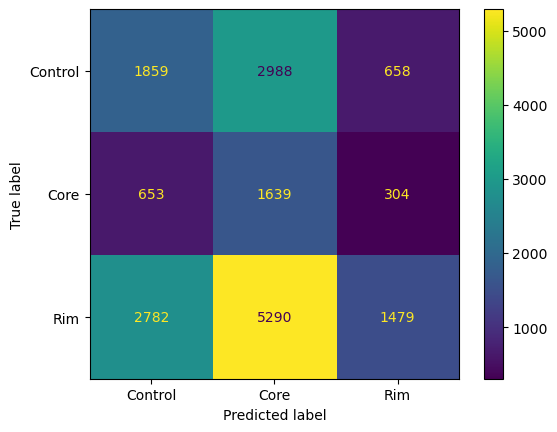

In [97]:
cm = confusion_matrix(
    rna_tissue[pivot_matching_filtered[0]], protein_tissue[pivot_matching_filtered[1]]
)
ConfusionMatrixDisplay(
    confusion_matrix=cm.T,
    display_labels=np.unique(rna_tissue),
).plot()

In [99]:
fusor.propagate(
    svd_components1=50,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Done!


In [100]:
fusor.filter_bad_matches(target="propagated", filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
145915/208448 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [101]:
full_matching = fusor.get_matching(order=(2, 1), target="full_data")

In [102]:
# Evaluate full matching
lv1_acc = mf.metrics.get_matching_acc(
    matching=full_matching,
    labels1=rna_pd1_levels,
    labels2=protein_pd1_levels,
    order=(2, 1),
)
lv1_acc

0.6934772906515373

Accuracy: 0.6934772906515373
F1-high: 0.5591537778403046
F1-low: 0.7650617370727021
F1-avg: 0.6621077574565033
              precision    recall  f1-score   support

    PD1-high       0.61      0.52      0.56     61390
     PD1-low       0.73      0.80      0.77    102177

    accuracy                           0.69    163567
   macro avg       0.67      0.66      0.66    163567
weighted avg       0.69      0.69      0.69    163567



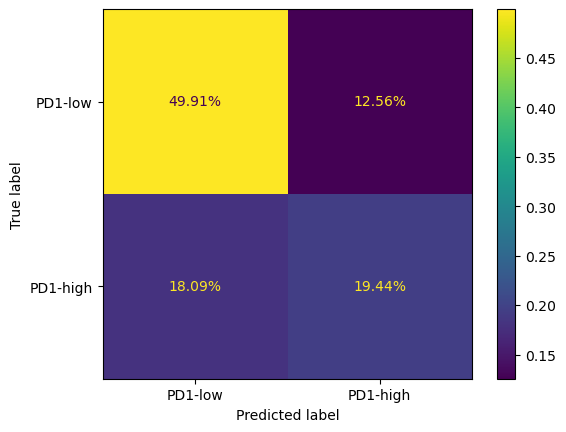

In [108]:
predicted_pd1_levels = rna_pd1_levels[full_matching[0]]
true_pd1_levels = protein_pd1_levels[full_matching[1]]

accuracy = accuracy_score(true_pd1_levels, predicted_pd1_levels)
f1_hi = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-high")
f1_low = f1_score(true_pd1_levels, predicted_pd1_levels, pos_label="PD1-low")

print("Accuracy:", accuracy)
print("F1-high:", f1_hi)
print("F1-low:", f1_low)
print("F1-avg:", (f1_low + f1_hi) / 2)


labels = ["PD1-low", "PD1-high"]

print(classification_report(true_pd1_levels, predicted_pd1_levels))

cm = confusion_matrix(true_pd1_levels, predicted_pd1_levels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm / np.sum(cm), display_labels=labels)
disp.plot(values_format=".2%")

In [56]:
pivot_matching = fusor.get_matching(order=(2, 1), target="pivot")

rna_tissue = np.array([x for x in sc_adata.obs["Tissue"]])

protein_tissue = [x for x in adata.obs["Tissue"]]
protein_tissue = ["Rim" if x == "rim" else x for x in adata.obs["Tissue"]]
protein_tissue = ["Core" if x == "core" else x for x in protein_tissue]
protein_tissue = np.array(
    ["Control" if x == "normalLiver" else x for x in protein_tissue]
)


lv1_acc = mf.metrics.get_matching_acc(
    matching=pivot_matching,
    labels1=rna_tissue,
    labels2=protein_tissue,
    order=(2, 1),
)
lv1_acc

0.2923050732039496

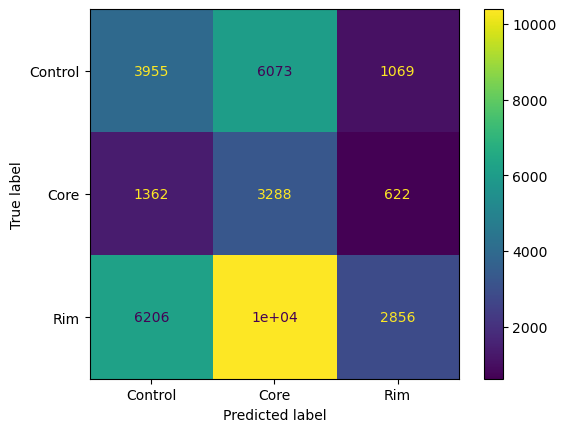

In [57]:
cm = confusion_matrix(rna_tissue[pivot_matching[0]], protein_tissue[pivot_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=cm.T,
    display_labels=np.unique(rna_tissue),
).plot()

In [110]:
adata.obs["Cluster label"] = pd.NA
scrna_labels_for_transfer = sc_adata.obs["Cluster label"][full_matching[0]]
adata.obs["Cluster label"].iloc[full_matching[1]] = scrna_labels_for_transfer

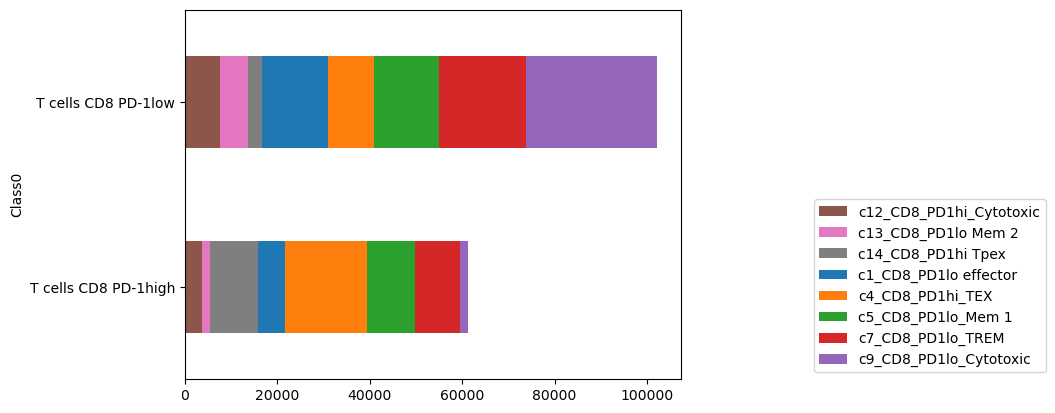

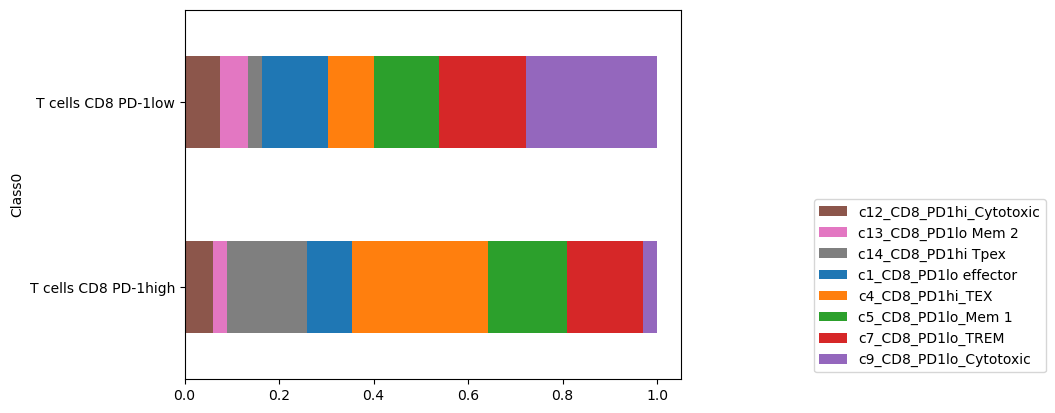

In [112]:
# Plot transferred celltypes
count_df_ = (
    adata.obs.value_counts(["Class0", "Cluster label"])
    .reset_index()
    .pivot(index="Class0", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True, color=CELLTYPE_COLOR_DICT)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True, color=CELLTYPE_COLOR_DICT)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

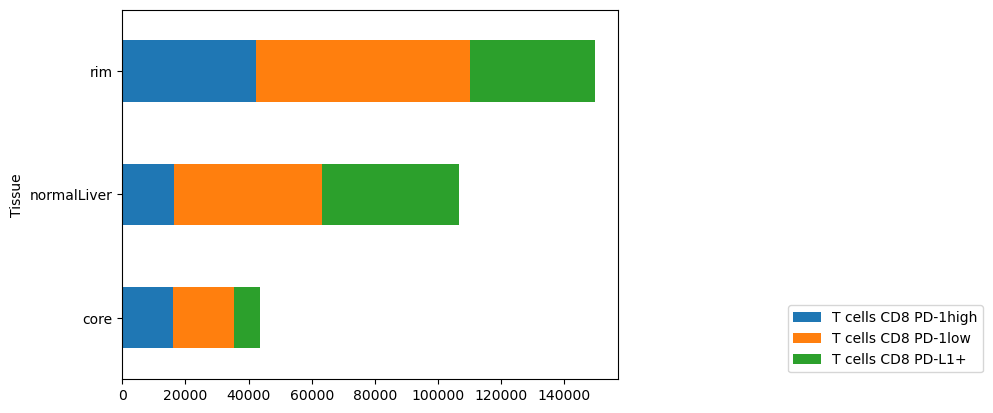

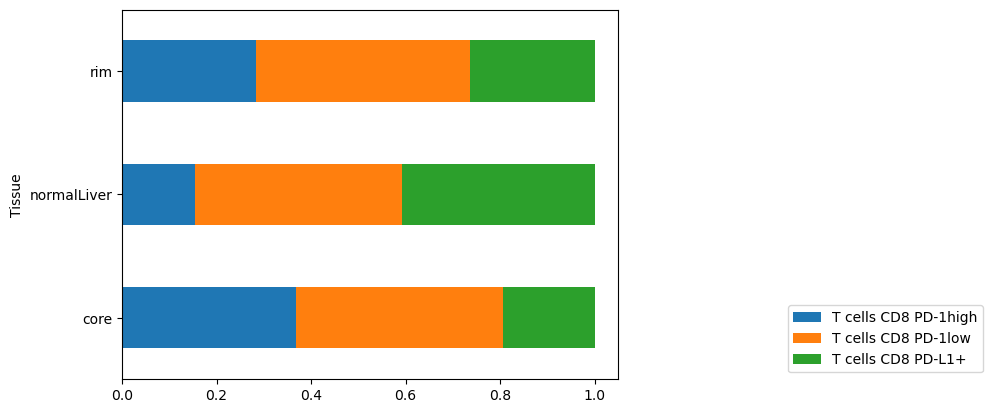

In [225]:
count_df_ = (
    adata.obs.value_counts(["Class0", "Tissue"])
    .reset_index()
    .pivot(index="Tissue", columns="Class0", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

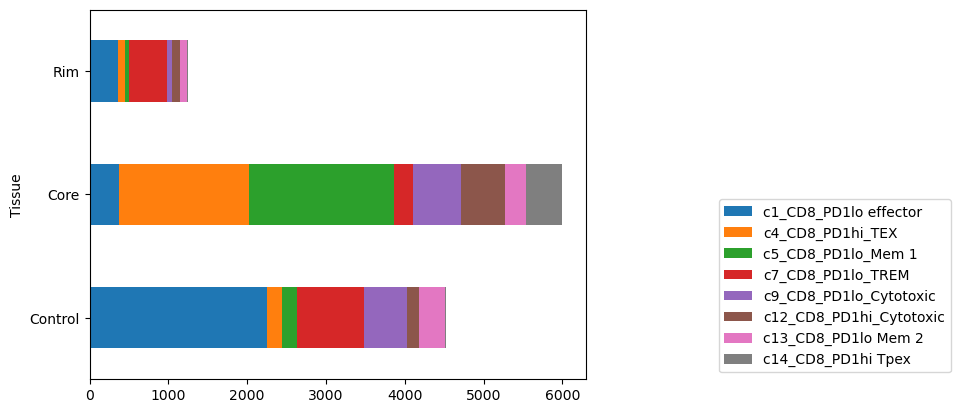

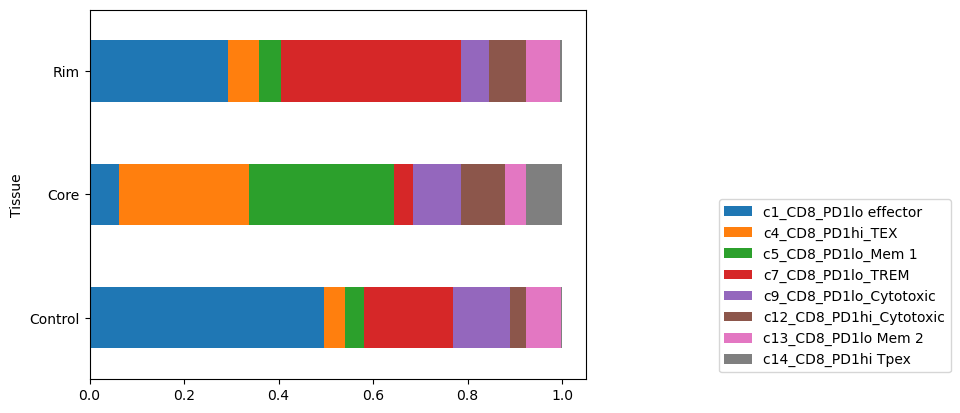

In [226]:
count_df_ = (
    sc_adata.obs.value_counts(["Tissue", "Cluster label"])
    .reset_index()
    .pivot(index="Tissue", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True, color=CELLTYPE_COLOR_DICT)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

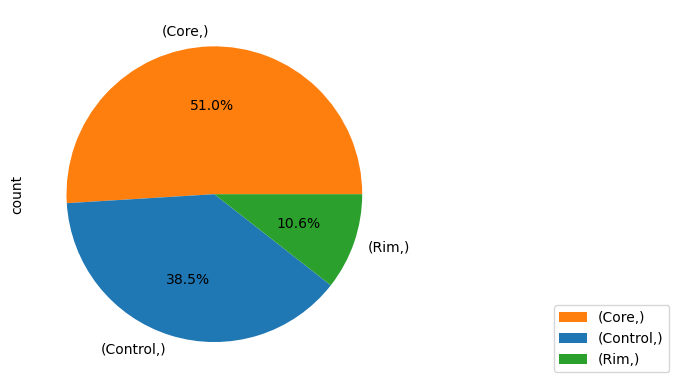

In [217]:
tissue_colors = {"Control": "#1f77b4", "Core": "#ff7f0e", "Rim": "#2ca02c"}
count_df_ = sc_adata.obs.value_counts(["Tissue"])

count_df_.plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=[tissue_colors[tissue[0]] for tissue in count_df_.index],
)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

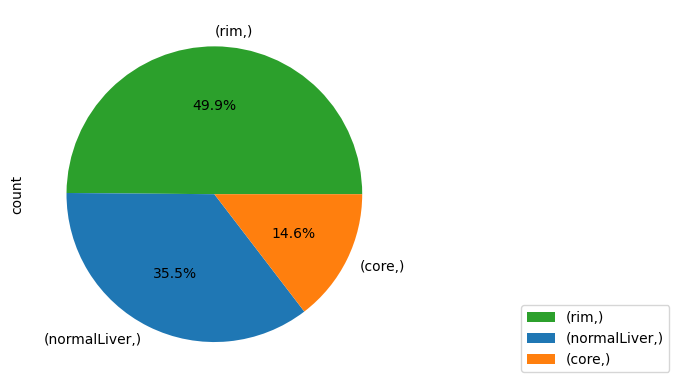

In [219]:
tissue_colors = {"normalLiver": "#1f77b4", "core": "#ff7f0e", "rim": "#2ca02c"}
count_df_ = adata.obs.value_counts(["Tissue"])

count_df_.plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=[tissue_colors[tissue[0]] for tissue in count_df_.index],
)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

# MaxFuse with all data

Run maxfuse utilising all CD8 T cells

In [122]:
import maxfuse as mf
import anndata
import pandas as pd
import scanpy as scp
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from matplotlib import colors

%load_ext jupyter_black

protein_map = pd.read_csv(
    "2022_11_16_Protein-Gene mapping_markers for data integration_edited.csv"
)

# remove non-relevant antigens
protein_map = protein_map[protein_map["Comment"].isnull()]
# remove whitespace from marker names
protein_map["Antigen (CODEX)"] = protein_map["Antigen (CODEX)"].str.strip()
protein_map["Gene"] = protein_map["Gene"].str.strip()

obs_columns = [
    "Unnamed: 0",
    "X",
    "index",
    "Object.Id",
    "XMin",
    "XMax",
    "YMin",
    "YMax",
    "Tissue",
    "Patient",
    "Celltype",
    "Class",
    "Class0",
]

marker_columns = [
    "CD56.Cytoplasm.Intensity",
    "CD161.Cytoplasm.Intensity",
    "TCRValpha.Cytoplasm.Intensity",
    "CD39.Cytoplasm.Intensity",
    "CD25.Cytoplasm.Intensity",
    "CD57.Cytoplasm.Intensity",
    "CD40.Cytoplasm.Intensity",
    "ICOS.Cytoplasm.Intensity",
    "CD3.Cytoplasm.Intensity",
    "CD62L.Cytoplasm.Intensity",
    "LYVE.1.Cytoplasm.Intensity",
    "CD45RO.Cytoplasm.Intensity",
    "IL18Ra.Cytoplasm.Intensity",
    "PD.L1.Cytoplasm.Intensity",
    "CD45.Cytoplasm.Intensity",
    "CD34.Cytoplasm.Intensity",
    "CD163.Cytoplasm.Intensity",
    "Ki67.Nucleus.Intensity",
    "CD19.Cytoplasm.Intensity",
    "CD38.Cytoplasm.Intensity",
    "CD279.Cytoplasm.Intensity",
    "CD11c.Cytoplasm.Intensity",
    "CD8.Cytoplasm.Intensity",
    "CD11b.Cytoplasm.Intensity",
    "CD16.Cytoplasm.Intensity",
    "FoxP3.Nucleus.Intensity",
    "CD69.Cytoplasm.Intensity",
    "CD15.Cytoplasm.Intensity",
    "HNFalpha.Nucleus.Intensity",
    "pancytokeratin.Cytoplasm.Intensity",
    "HLADR.Cytoplasm.Intensity",
    "CD45RA.Cytoplasm.Intensity",
    "aSMA.Cytoplasm.Intensity",
    "CD4.Cytoplasm.Intensity",
    "CD66b.Cytoplasm.Intensity",
    "CD68.Cytoplasm.Intensity",
    "EPCAM.Cytoplasm.Intensity",
]

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [ ]:
markers = []
for column in marker_columns:
    if "Intensity" in column:
        markers.append("-".join(column.split(".")[:-2]))
markers
adata = anndata.read("CODEX_cd8.h5ad")

sc_adata = anndata.read("adata_CD8_velocity_all.h5ad")

protein_map_dict = {}
for marker in markers:
    gene_aliases = protein_map[protein_map["Antigen (CODEX)"] == marker][
        "Gene"
    ].values.reshape(-1)
    # print(marker, gene_aliases)
    protein_map_dict[marker] = []
    for gene_name in gene_aliases:
        split = gene_name.split(",")
        for name in split:
            protein_map_dict[marker].append(name.strip())


markers_to_keep = []
genes_to_keep = []
for key, values in protein_map_dict.items():
    for gene in values:  # if protein matches to more than one gene
        if (
            gene in sc_adata.var[sc_adata.var["highly_variable"]].index.values
        ):  # keep only higly variable genes
            genes_to_keep.append(gene)
            markers_to_keep.append(key)  # repeat marker
        else:
            print(gene)

adata.var_names = markers
adata_compare = adata[:, markers_to_keep].copy()

In [124]:
sc_adata.X = sc_adata.raw.X.copy()
sc_adata_compare = sc_adata[:, genes_to_keep].copy()

sc_adata.X = sc_adata.raw.X.copy()
sc_adata_compare = sc_adata[:, genes_to_keep].copy()

scp.pp.normalize_total(sc_adata)
scp.pp.log1p(sc_adata)
scp.pp.scale(sc_adata)

scp.pp.normalize_total(sc_adata_compare)
scp.pp.log1p(sc_adata_compare)
scp.pp.scale(sc_adata_compare)

rna_shared = sc_adata_compare.X.copy()
protein_shared = adata_compare.X.copy()
rna_active = sc_adata[:, sc_adata.var["highly_variable"]].X
protein_active = adata.X

rna_active = rna_active.toarray()

In [125]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=sc_adata.obs["Cluster label"],
    labels2=None,
)

In [126]:
fusor.split_into_batches(
    max_outward_size=8000, matching_ratio=4, metacell_size=2, verbose=True
)

The first data is split into 1 batches, average batch size is 11766, and max batch size is 11766.
The second data is split into 9 batches, average batch size is 33314, and max batch size is 33314.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8'].


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

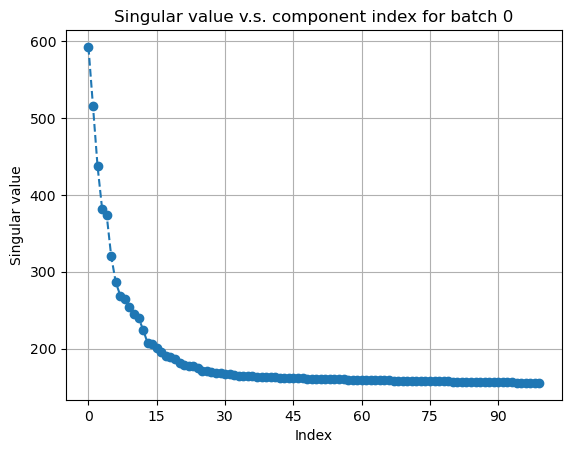

In [127]:
fusor.plot_singular_values(
    target="active_arr1",
    n_components=None,  # can also explicitly specify the number of components
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

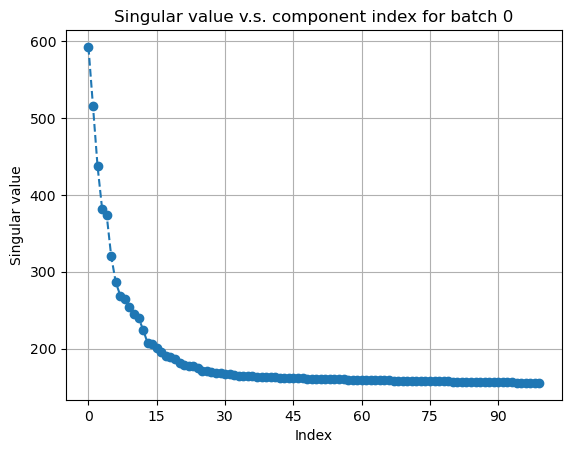

In [128]:
fusor.plot_singular_values(
    target="active_arr1",
    n_components=None,  # can also explicitly specify the number of components
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 5'}, xlabel='Index', ylabel='Singular value'>)

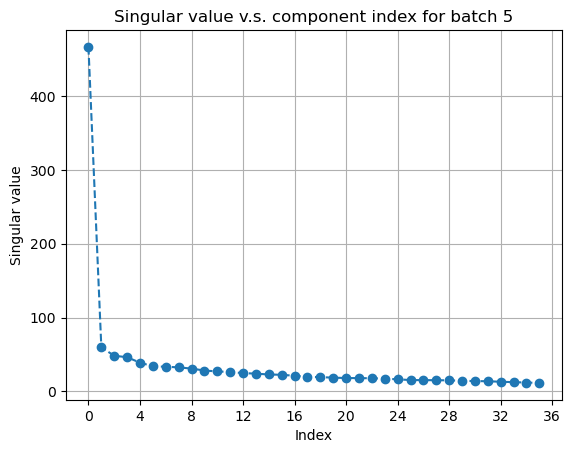

In [129]:
fusor.plot_singular_values(target="active_arr2", n_components=None)

In [130]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=10,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True,
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Now at batch 8...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Now at batch 8...
Graph clustering finished!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

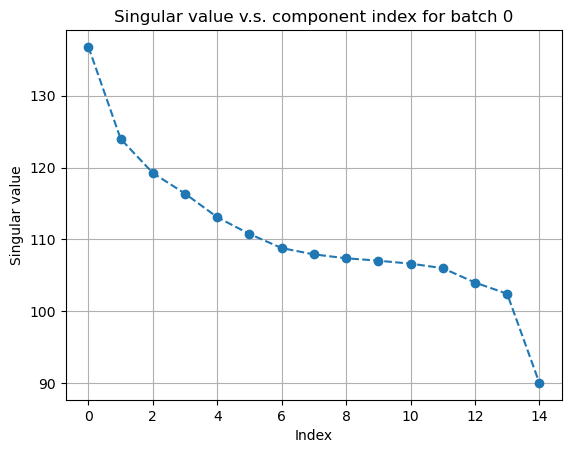

In [131]:
fusor.plot_singular_values(
    target="shared_arr1",
    n_components=None,
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 4'}, xlabel='Index', ylabel='Singular value'>)

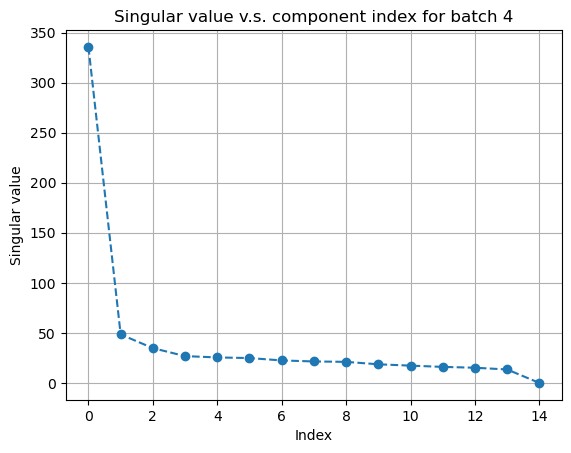

In [132]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(target="shared_arr2", n_components=None)

In [133]:
fusor.find_initial_pivots(wt1=0.3, wt2=0.3, svd_components1=14, svd_components2=10)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Done!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->8'}, xlabel='Index', ylabel='Canonical correlation'>)

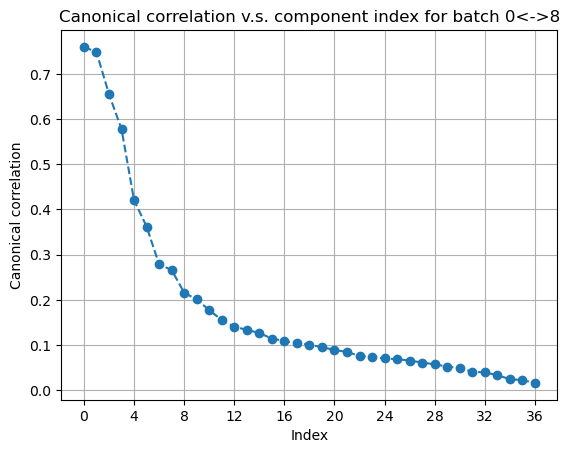

In [134]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50, svd_components2=None, cca_components=37
)

In [135]:
fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=50,
    svd_components2=None,
    cca_components=30,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Done!


In [136]:
fusor.filter_bad_matches(target="pivot", filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
26487/52965 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
9245/11766 cells in arr1 are selected as pivots.
26487/299826 cells in arr2 are selected as pivots.
Done!


In [137]:
fusor.propagate(
    svd_components1=50,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Done!


In [138]:
fusor.filter_bad_matches(target="propagated", filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
209871/299817 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [139]:
full_matching = fusor.get_matching(order=(2, 1), target="full_data")

In [140]:
import pickle

with open("max_fuse_full_matching_all_cd8.pkl", "wb") as f:
    pickle.dump(full_matching, f)

In [ ]:
# Look at the joint embedding data
rna_cca, protein_cca_sub = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2[
        full_matching[1], :
    ],  # cells in codex remaining after filtering
)

In [ ]:
cca_adata = anndata.AnnData(
    np.concatenate((rna_cca, protein_cca_sub), axis=0),
    dtype=np.float32,
)
cca_adata.obs["data_type"] = ["rna"] * rna_cca.shape[0] + [
    "protein"
] * protein_cca_sub.shape[0]

rna_celltypes = np.array(sc_adata.obs["Cluster label"].values)

cca_adata.obs["Cluster label"] = list(
    np.concatenate([rna_celltypes, rna_celltypes[full_matching[0]]])
)

cca_adata.obs["Patient"] = list(
    np.concatenate(
        [sc_adata.obs["Patient"], adata.obs["Patient"].iloc[full_matching[1]]]
    )
)

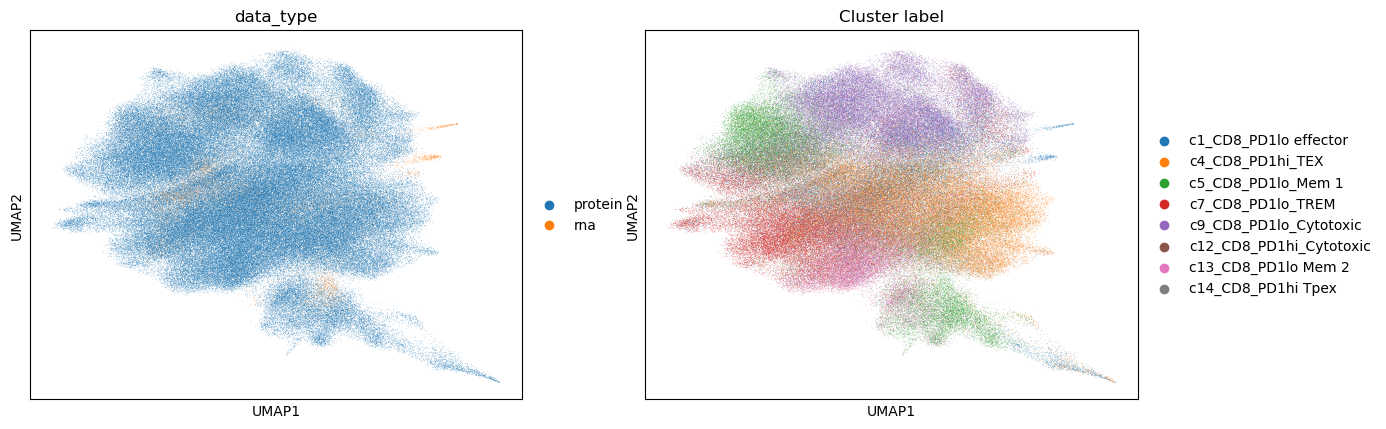

In [26]:
scp.pl.umap(cca_adata, color=["data_type", "Cluster label"])

In [27]:
# Add spatial coordinates to CODEX cells in joint embeddings
adata.obs["XMean"] = (adata.obs["XMax"] + adata.obs["XMin"]) / 2
adata.obs["YMean"] = (adata.obs["YMax"] + adata.obs["YMin"]) / 2
adata.obsm["X_spatial"] = np.stack(
    [adata.obs["XMean"].values, adata.obs["YMean"].values], axis=1
)

X_spatial_buffer = np.array([[[0.0, 0.0]] * len(sc_adata)])[0]

cca_adata.obsm["X_spatial"] = np.concatenate(
    [X_spatial_buffer, adata.obsm["X_spatial"][full_matching[1]]]
)

In [28]:
# Save integrated data   
cca_adata.write("maxfuse_cca_adata_all_patients_less_markers_PDl1.h5ad")

In [30]:
# Add labels to the codex data 
adata.obs["Cluster label"] = pd.NA
scrna_labels_for_transfer = sc_adata.obs["Cluster label"][full_matching[0]]
adata.obs["Cluster label"].iloc[full_matching[1]] = scrna_labels_for_transfer

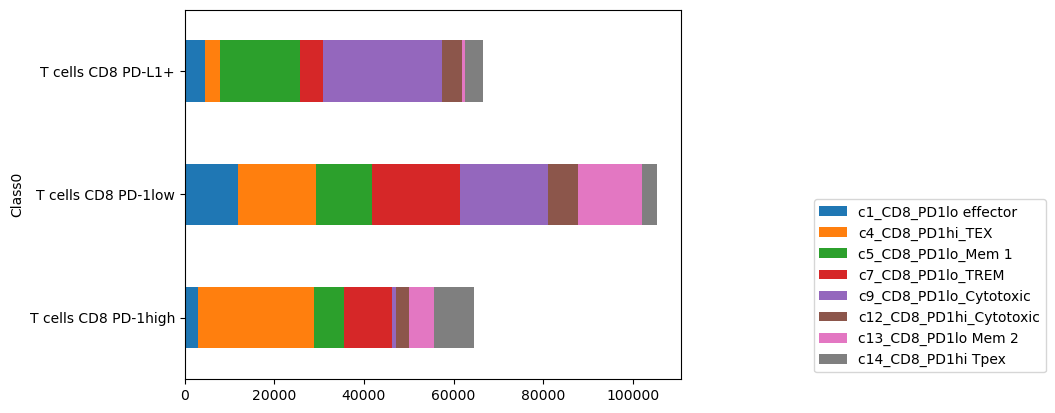

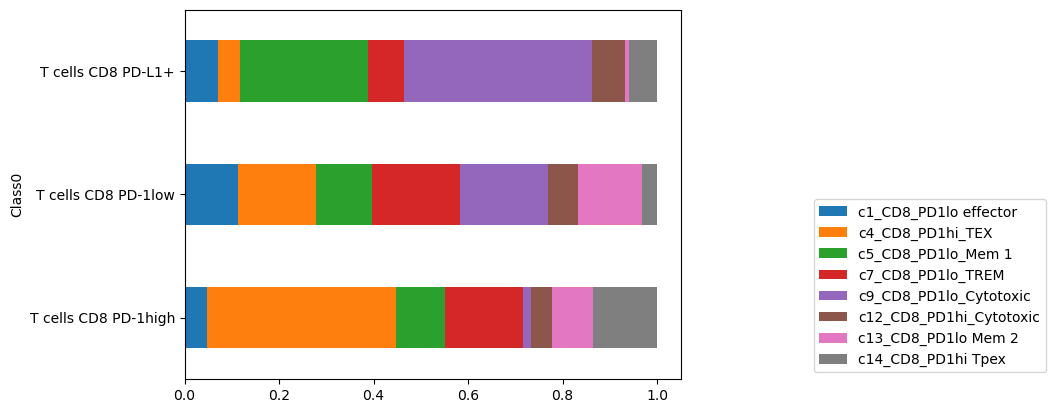

In [32]:
count_df_ = (
    adata.obs.value_counts(["Class0", "Cluster label"])
    .reset_index()
    .pivot(index="Class0", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

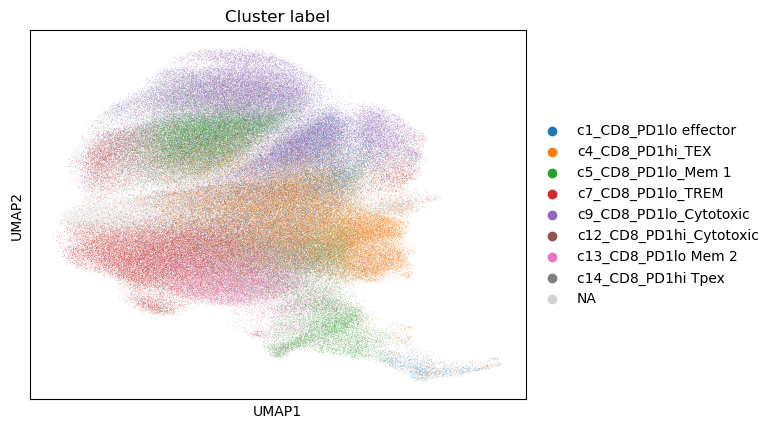

In [33]:
scp.pp.neighbors(adata, n_neighbors=30)
scp.tl.umap(adata)
scp.pl.umap(adata, color="Cluster label")

In [34]:
# Save jus the CODEX data with transferred labels
adata.write("adata_cd8_codex_label_transfer_good.h5ad")